In [229]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import json
import requests

import pymongo
from pymongo import MongoClient
from pprint import pprint


'''
Mongo shell commands to create geoloc field in each document and create an index on geoloc

db.Yelp.aggregate([
   { $addFields: { 
    geoloc: {
      "type" : "Point",
      "coordinates" : [
        {"$toDecimal" : "$longitude"},
        {"$toDecimal" : "$latitude"}
        ]
      }
    }
  },
  { $out : "YelpGeo" }
])

db.Yelp.createIndex( { geoloc : "2dsphere" } )
'''

'\nMongo shell commands to create geoloc field in each document and create an index on geoloc\n\ndb.Yelp.aggregate([\n   { $addFields: { \n    geoloc: {\n      "type" : "Point",\n      "coordinates" : [\n        {"$toDecimal" : "$longitude"},\n        {"$toDecimal" : "$latitude"}\n        ]\n      }\n    }\n  },\n  { $out : "YelpGeo" }\n])\n\ndb.Yelp.createIndex( { geoloc : "2dsphere" } )\n'

# PyMongo Setup and Querying

In [230]:
client = MongoClient()
db = client['DS4300']
yelp_collection = db['YelpGeo']

In [231]:
# Example document
pprint(yelp_collection.find_one())

{'_id': ObjectId('622198b2b5127b859164a21e'),
 'address': '921 Pearl St',
 'attributes': {'Alcohol': "'beer_and_wine'",
                'Ambience': "{'touristy': False, 'hipster': False, 'romantic': "
                            "False, 'divey': False, 'intimate': False, "
                            "'trendy': False, 'upscale': False, 'classy': "
                            "False, 'casual': True}",
                'BikeParking': 'True',
                'BusinessAcceptsBitcoin': 'False',
                'BusinessAcceptsCreditCards': 'True',
                'BusinessParking': "{'garage': False, 'street': True, "
                                   "'validated': False, 'lot': False, 'valet': "
                                   'False}',
                'Caters': 'True',
                'DogsAllowed': 'False',
                'GoodForMeal': "{'dessert': False, 'latenight': False, "
                               "'lunch': False, 'dinner': False, 'brunch': "
                              

#### Q1. How many establishments are there total, how many have 5 stars?

In [235]:
print(yelp_collection.count_documents({}))

establishments_5_stars = yelp_collection.find({'stars': 5})
print(len(list(establishments_5_stars)))

160585
19953


#### Q2. Which establishment has the least stars and what city is it in?

In [237]:
least_stars = yelp_collection.find_one(sort=[('stars', 1)])
print(least_stars['name'] + ', ' + least_stars['city'])

Magical Pizza Express, Orlando


#### Q3. What is the number of establishments for each star rating?

In [239]:
star_counts = yelp_collection.aggregate(
        [{"$group" : 
            {"_id" : "$stars", 
            "num_establishments" : {"$sum" : 1}
         }},
         {'$sort' : 
            {'_id' : 1}}
    ])
    
for i in star_counts:
    pprint(i)

{'_id': 1, 'num_establishments': 1686}
{'_id': 1.5, 'num_establishments': 4157}
{'_id': 2, 'num_establishments': 8523}
{'_id': 2.5, 'num_establishments': 13720}
{'_id': 3, 'num_establishments': 21583}
{'_id': 3.5, 'num_establishments': 28835}
{'_id': 4, 'num_establishments': 34056}
{'_id': 4.5, 'num_establishments': 28072}
{'_id': 5, 'num_establishments': 19953}


#### Q4. What is the number of establishments for each star rating, specifically in Boston?

In [240]:
boston_star_counts = yelp_collection.aggregate(
        [
            { '$match' : { 'city' : 'Boston' } },
            {"$group" : 
                {"_id" : "$stars", 
                "num_establishments" : {"$sum" : 1}
                }
            },
            {'$sort' : {'_id' : 1}}
    ])
    
for i in boston_star_counts:
    pprint(i)

{'_id': 1, 'num_establishments': 97}
{'_id': 1.5, 'num_establishments': 194}
{'_id': 2, 'num_establishments': 395}
{'_id': 2.5, 'num_establishments': 705}
{'_id': 3, 'num_establishments': 1233}
{'_id': 3.5, 'num_establishments': 1674}
{'_id': 4, 'num_establishments': 1788}
{'_id': 4.5, 'num_establishments': 1312}
{'_id': 5, 'num_establishments': 865}


#### Q5. What is the average star count and the total number of reviews for each city, sorted by number of reviews descending?

In [257]:
avg_stars_per_city_and_counts = yelp_collection.aggregate(
        [
            {"$group" : 
                {"_id" : "$city", 
                "avg_stars" : {"$avg" : "$stars"},
                "num_reviews" : {"$sum" : 1}
            }},
                        
            {'$sort' : {'num_reviews' : -1}},
    ])
    
for i, item in enumerate(avg_stars_per_city_and_counts):
    if i < 10:
        pprint(item)
    else:
        break

{'_id': 'Austin', 'avg_stars': 3.8545681655960027, 'num_reviews': 22416}
{'_id': 'Portland', 'avg_stars': 3.9191342086469265, 'num_reviews': 18203}
{'_id': 'Vancouver', 'avg_stars': 3.611515378844711, 'num_reviews': 13330}
{'_id': 'Atlanta', 'avg_stars': 3.523826514430701, 'num_reviews': 12612}
{'_id': 'Orlando', 'avg_stars': 3.5376045877597067, 'num_reviews': 10637}
{'_id': 'Boston', 'avg_stars': 3.6160595425390296, 'num_reviews': 8263}
{'_id': 'Columbus', 'avg_stars': 3.54009647271631, 'num_reviews': 6634}
{'_id': 'Boulder', 'avg_stars': 3.7793076317859953, 'num_reviews': 2542}
{'_id': 'Cambridge', 'avg_stars': 3.6496095355528153, 'num_reviews': 2433}
{'_id': 'Beaverton', 'avg_stars': 3.6949378330373004, 'num_reviews': 2252}


#### Q6. What is the distribution of average star counts for each city, including each city's coordinates?

In [253]:
avg_stars_per_city = yelp_collection.aggregate(
        [
            {"$group" : 
                {"_id" : "$city",
                    "latitude" : {"$avg" : "$latitude"},
                    "longitude" : {"$avg" : "$longitude"},
                    "avg_stars" : {"$avg" : "$stars"}
                }
            }
    ])

avg_stars_list = list(avg_stars_per_city)
    
for i, item in enumerate(avg_stars_list):
    if i < 5:
        pprint(item)
    else:
        break

{'_id': 'Altamonte Springs',
 'avg_stars': 3.4731800766283527,
 'latitude': 28.6647602866696,
 'longitude': -81.39371811195926}
{'_id': 'Ocoee',
 'avg_stars': 3.577639751552795,
 'latitude': 28.556479655476085,
 'longitude': -81.53176501550652}
{'_id': 'Spring Valley',
 'avg_stars': 5.0,
 'latitude': 42.4114714,
 'longitude': -71.012537}
{'_id': 'Prontland',
 'avg_stars': 5.0,
 'latitude': 45.455382,
 'longitude': -122.5861553}
{'_id': 'E Boston',
 'avg_stars': 3.5,
 'latitude': 42.3735248,
 'longitude': -71.0406306}


#### Data Visualization

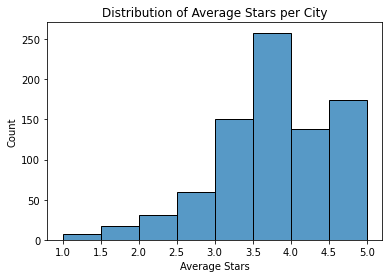

In [254]:
# Process PyMongo output for data visualizations

avg_star_data = []
lat_data = []
long_data = []

for record in avg_stars_list:
    avg_star_data.append(record['avg_stars'])
    lat_data.append(record['latitude'])
    long_data.append(record['longitude'])

sns.histplot(x=avg_star_data, bins=8)
plt.title('Distribution of Average Stars per City')
plt.xlabel('Average Stars')
plt.savefig('avg_stars_per_city.png', bbox_inches = 'tight')

#### Visualization Interpretation:
The visualization reveals that the distribution of the average star ratings per city is <u>unimodal</u> and <u>heavily skewed to the left</u>. It appears <u>centered on 3.5 - 4 stars</u>. This means that average star ratings per city tend to be on the higher end, with very few cities having a low average rating. Additionally, it's revealed that more cities have the highest average rating of 4.5 - 5 stars compared to those just below with 4 - 4.5 stars, which is surprising to see. However, this may be due to the fact that when a city has some highly rated establishments, their surrounding businesses must also provide great products and services in order to compete and remain in business. Therefore highly rated businesses will be clustered together, and thus raise the frequency of cities that have the highest average rating.

#### Data Visualization 2 (Ignore)

Text(0.5, 6.79999999999999, 'Latitude')

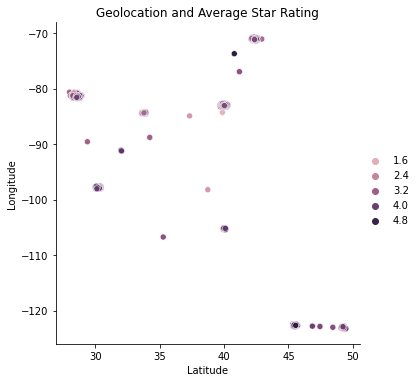

In [255]:
scatter = sns.relplot(x=lat_data, y=long_data, hue=avg_star_data, legend=True)
plt.title('Geolocation and Average Star Rating')
plt.ylabel('Longitude')
plt.xlabel('Latitude')
# plt.savefig('geolocation_and_avg_stars.png', bbox_inches = 'tight')

#### Q7. How many locations are within 5000 meters of Mr G's Pizza & Subs?

In [213]:
target = yelp_collection.find_one({'name' : 'Mr G\'s Pizza & Subs'})['geoloc']

res = yelp_collection.find({
    "geoloc": {
        '$near': {
            '$geometry':
                target,
                '$maxDistance': 5000
        }
    }
})

len(list(res))

1122

#### Q8. What are the 10 nearest establishments to Northeastern's Boston campus, sorted alphabetically by name?

In [244]:
close_to_nu = yelp_collection.aggregate([
  { "$geoNear": {
     "near": {'type' : 'Point', 'coordinates' : [ 71.0892, 42.3398 ] },
     "distanceField": "distance"
    }
  },
  {
    '$limit' : 10
  },
  {
    '$sort' : {'name' : 1}
  }
])

nu_list = list(close_to_nu)
for place in nu_list:
  print(place['name'])

Artisan Eats Cafe & Fine Foods
Cocoa West Chocolatier
Cypress Mountain
Eagle Bluffs
JPizle Kitchen
Karen Magnussen Community Recreation Centre
Killarney Lake
Lions Bay General Store and Cafe
Sea to Sky Highway
St. Mark's Summit


#### Q9. What proportion of all the establishments have 4+ stars and 10+ reviews?

In [245]:
good_places = yelp_collection.find(
                                    {'stars': {'$gte' : 4},
                                    'review_count' : {'$gte' : 10}
                                })
                                
round(len(list(good_places)) / yelp_collection.count_documents({}), 3)

0.348

##### Q10. What proportion of establishments North of Kansas are highly rated? What about the proportion South of Kansas? (Kansas is the geographical center of the U.S.)

In [246]:
n_kansas_and_high = yelp_collection.count_documents( {'$and' : [ {'latitude' : {'$gt':40 }}, {'stars' : {'$gte': 4.5 }} ]})
n_kansas = yelp_collection.count_documents( {'latitude' : {'$gt': 40 }} )
print(f'North of Kansas: {round(n_kansas_and_high/n_kansas, 3)}')

s_kansas_and_high = yelp_collection.count_documents( {'$and' : [ {'latitude' : {'$lt': 37 }}, {'stars' : {'$gte': 4.5 }} ]})
s_kansas = yelp_collection.count_documents( {'latitude' : {'$lt': 37 }} )
print(f'South of Kansas: {round(s_kansas_and_high/s_kansas, 3)}')

North of Kansas: 0.294
South of Kansas: 0.311
